# EGS master catalogue
## Preparation of CANDELS-EGS data

CANDELS-EGS catalogue: the catalogue comes from `dmu0_CANDELS-EGS`.

In the catalogue, we keep:

- The identifier (it's unique in the catalogue);
- The position;
- The stellarity;
- The magnitude for each band in 2 arcsec aperture (aperture 10).
- The kron magnitude to be used as total magnitude (no “auto” magnitude is provided).

We don't know when the maps have been observed. We will use the year of the reference paper.

In [1]:
from herschelhelp_internal import git_version
print("This notebook was run with herschelhelp_internal version: \n{}".format(git_version()))
import datetime
print("This notebook was executed on: \n{}".format(datetime.datetime.now()))

This notebook was run with herschelhelp_internal version: 
44f1ae0 (Thu Nov 30 18:27:54 2017 +0000)


In [2]:
%matplotlib inline
#%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt
plt.rc('figure', figsize=(10, 6))

from collections import OrderedDict
import os

from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.table import Column, Table
import numpy as np

from herschelhelp_internal.flagging import  gaia_flag_column
from herschelhelp_internal.masterlist import nb_astcor_diag_plot, remove_duplicates
from herschelhelp_internal.utils import astrometric_correction, flux_to_mag

In [3]:
OUT_DIR =  os.environ.get('TMP_DIR', "./data_tmp")
try:
    os.makedirs(OUT_DIR)
except FileExistsError:
    pass

RA_COL = "candels-egs_ra"
DEC_COL = "candels-egs_dec"

## I - Column selection

In [4]:
imported_columns = OrderedDict({
        'ID': "candels-egs_id",
        'RA': "candels-egs_ra",
        'DEC': "candels-egs_dec",
        'CLASS_STAR':  "candels-egs_stellarity",
    #HST data
        'FLUX_APER_10_F606W': "f_ap_acs_f606w", 
        'FLUXERR_APER_10_F606W': "ferr_ap_acs_f606w", 
        'FLUX_AUTO_F606W': "f_acs_f606w", 
        'FLUXERR_AUTO_F606W': "ferr_acs_f606w",
        'FLUX_APER_10_F814W': "f_ap_acs_f814w", 
        'FLUXERR_APER_10_F814W': "ferr_ap_acs_f814w", 
        'FLUX_AUTO_F814W': "f_acs_f814w", 
        'FLUXERR_AUTO_F814W': "ferr_acs_f814w",
        'FLUX_APER_10_F125W': "f_ap_wfc3_f125w", 
        'FLUXERR_APER_10_F125W': "ferr_ap_wfc3_f125w", 
        'FLUX_AUTO_F125W': "f_wfc3_f125w", 
        'FLUXERR_AUTO_F125W': "ferr_wfc3_f125w",
        'FLUX_APER_10_F140W': "f_ap_wfc3_f140w", 
        'FLUXERR_APER_10_F140W': "ferr_ap_wfc3_f140w", 
        'FLUX_AUTO_F140W': "f_wfc3_f140w", 
        'FLUXERR_AUTO_F140W': "ferr_wfc3_f140w",
        'FLUX_APER_10_F160W': "f_ap_wfc3_f160w", 
        'FLUXERR_APER_10_F160W': "ferr_ap_wfc3_f160w", 
        'FLUX_AUTO_F160W': "f_wfc3_f160w", 
        'FLUXERR_AUTO_F160W': "ferr_wfc3_f160w",
    #CFHT Megacam
        'CFHT_u_FLUX': "f_candels-megacam_u", # 9 CFHT_u_FLUX Flux density (in μJy) in the u*-band (CFHT/MegaCam) (3)
        'CFHT_u_FLUXERR': "ferr_candels-megacam_u",# 10 CFHT_u_FLUXERR Flux uncertainty (in μJy) in the u*-band (CFHT/MegaCam) (3)
        'CFHT_g_FLUX': "f_candels-megacam_g",# 11 CFHT_g_FLUX Flux density (in μJy) in the g'-band (CFHT/MegaCam) (3)
        'CFHT_g_FLUXERR': "ferr_candels-megacam_g",# 12 CFHT_g_FLUXERR Flux uncertainty (in μJy) in the g'-band (CFHT/MegaCam) (3)
        'CFHT_r_FLUX': "f_candels-megacam_r",# 13 CFHT_r_FLUX Flux density (in μJy) in the r'-band (CFHT/MegaCam) (3)
        'CFHT_r_FLUXERR': "ferr_candels-megacam_r",# 14 CFHT_r_FLUXERR Flux uncertainty (in μJy) in the r'-band (CFHT/MegaCam) (3)
        'CFHT_i_FLUX': "f_candels-megacam_i",# 15 CFHT_i_FLUX Flux density (in μJy) in the i'-band (CFHT/MegaCam) (3)
        'CFHT_i_FLUXERR': "ferr_candels-megacam_i",# 16 CFHT_i_FLUXERR Flux uncertainty (in μJy) in the i'-band (CFHT/MegaCam) (3)
        'CFHT_z_FLUX': "f_candels-megacam_z",# 17 CFHT_z_FLUX Flux density (in μJy) in the z'-band (CFHT/MegaCam) (3)
        'CFHT_z_FLUXERR': "ferr_candels-megacam_z",# 18 CFHT_z_FLUXERR 
    #CFHT WIRCAM
        'WIRCAM_J_FLUX': "f_candels-wircam_j",# 29 WIRCAM_J_FLUX Flux density (in μJy) in the J-band (CFHT/WIRCam) (3)
        'WIRCAM_J_FLUXERR': "ferr_candels-wircam_j",# 30 WIRCAM_J_FLUXERR Flux uncertainty (in μJy) in the J-band (CFHT/WIRCam) (3)
        'WIRCAM_H_FLUX': "f_candels-wircam_h",# 31 WIRCAM_H_FLUX Flux density (in μJy) in the H-band (CFHT/WIRCam) (3)
        'WIRCAM_H_FLUXERR': "ferr_candels-wircam_h",# 32 WIRCAM_H_FLUXERR Flux uncertainty (in μJy) in the H-band (CFHT/WIRCam) (3)
        'WIRCAM_K_FLUX': "f_candels-wircam_k",# 33 WIRCAM_K_FLUX Flux density (in μJy) in the Ks-band (CFHT/WIRCam) (3)
        'WIRCAM_K_FLUXERR': "ferr_candels-wircam_k",# 34 WIRCAM_K_FLUXERR 
    #Mayall/Newfirm
        'NEWFIRM_J1_FLUX': "f_candels-newfirm_j1",# 35 NEWFIRM_J1_FLUX Flux density (in μJy) in the J1-band (Mayall/NEWFIRM) (3)
        'NEWFIRM_J1_FLUXERR': "ferr_candels-newfirm_j1",# 36 NEWFIRM_J1_FLUXERR Flux uncertainty (in μJy) in the J1-band (Mayall/NEWFIRM) (3)
        'NEWFIRM_J2_FLUX': "f_candels-newfirm_j2",# 37 NEWFIRM_J2_FLUX Flux density (in μJy) in the J2-band (Mayall/NEWFIRM) (3)
        'NEWFIRM_J2_FLUXERR': "ferr_candels-newfirm_j2",# 38 NEWFIRM_J2_FLUXERR Flux uncertainty (in μJy) in the J2-band (Mayall/NEWFIRM) (3)
        'NEWFIRM_J3_FLUX': "f_candels-newfirm_j3",# 39 NEWFIRM_J3_FLUX Flux density (in μJy) in the J3-band (Mayall/NEWFIRM) (3)
        'NEWFIRM_J3_FLUXERR': "ferr_candels-newfirm_j3",# 40 NEWFIRM_J3_FLUXERR Flux uncertainty (in μJy) in the J3-band (Mayall/NEWFIRM) (3)
        'NEWFIRM_H1_FLUX': "f_candels-newfirm_h1",# 41 NEWFIRM_H1_FLUX Flux density (in μJy) in the H1-band (Mayall/NEWFIRM) (3)
        'NEWFIRM_H1_FLUXERR': "ferr_candels-newfirm_h1",# 42 NEWFIRM_H1_FLUXERR Flux uncertainty (in μJy) in the H1-band (Mayall/NEWFIRM) (3)
        'NEWFIRM_H2_FLUX': "f_candels-newfirm_h2",# 43 NEWFIRM_H2_FLUX Flux density (in μJy) in the H2-band (Mayall/NEWFIRM) (3)
        'NEWFIRM_H2_FLUXERR': "ferr_candels-newfirm_h2",# 44 NEWFIRM_H2_FLUXERR Flux uncertainty (in μJy) in the H2-band (Mayall/NEWFIRM) (3)
        'NEWFIRM_K_FLUX': "f_candels-newfirm_k",# 45 NEWFIRM_K_FLUX Flux density (in μJy) in the K-band (Mayall/NEWFIRM) (3)
        'NEWFIRM_K_FLUXERR': "ferr_candels-newfirm_k",# 46 NEWFIRM_K_FLUXERR 
    #Spitzer/IRAC
        'IRAC_CH1_FLUX': "f_candels-irac_i1",# 47 IRAC_CH1_FLUX Flux density (in μJy) in the 3.6μm-band (Spitzer/IRAC) (3)
        'IRAC_CH1_FLUXERR': "ferr_candels-irac_i1",# 48 IRAC_CH1_FLUXERR Flux uncertainty (in μJy) in the 3.6μm-band (Spitzer/IRAC) (3)
        'IRAC_CH2_FLUX': "f_candels-irac_i2",# 49 IRAC_CH2_FLUX Flux density (in μJy) in the 4.5μm-band (Spitzer/IRAC) (3)
        'IRAC_CH2_FLUXERR': "ferr_candels-irac_i2",# 50 IRAC_CH2_FLUXERR Flux uncertainty (in μJy) in the 4.5μm-band (Spitzer/IRAC) (3)
        'IRAC_CH3_FLUX': "f_candels-irac_i3",# 51 IRAC_CH3_FLUX Flux density (in μJy) in the 5.8μm-band (Spitzer/IRAC) (3)
        'IRAC_CH3_FLUXERR': "ferr_candels-irac_i3",# 52 IRAC_CH3_FLUXERR Flux uncertainty (in μJy) in the 5.8μm-band (Spitzer/IRAC) (3)
        'IRAC_CH4_FLUX': "f_candels-irac_i4",# 53 IRAC_CH4_FLUX Flux density (in μJy) in the 8.0μm-band (Spitzer/IRAC) (3)
        'IRAC_CH4_FLUXERR': "ferr_candels-irac_i4"# 54 IRAC_CH4_FLUXERR
    
    
    })


catalogue = Table.read("../../dmu0/dmu0_CANDELS-EGS/data/hlsp_candels_hst_wfc3_egs-tot-multiband_f160w_v1_cat.fits")[list(imported_columns)]
for column in imported_columns:
    catalogue[column].name = imported_columns[column]

epoch = 2011

# Clean table metadata
catalogue.meta = None

In [5]:
# Adding flux and band-flag columns
for col in catalogue.colnames:
    if col.startswith('f_'):
        
        errcol = "ferr{}".format(col[1:])
        
        # Some object have a magnitude to 0, we suppose this means missing value
        #catalogue[col][catalogue[col] <= 0] = np.nan
        #catalogue[errcol][catalogue[errcol] <= 0] = np.nan  
        

        mag, error = flux_to_mag(np.array(catalogue[col])*1.e-6, np.array(catalogue[errcol])*1.e-6)
        
        # Fluxes are added in µJy
        catalogue.add_column(Column(mag, name="m{}".format(col[1:])))
        catalogue.add_column(Column(error, name="m{}".format(errcol[1:])))
        
        # Add nan col for aperture fluxes
        if ('wfc' not in col) & ('acs' not in col):
            catalogue.add_column(Column(np.full(len(catalogue), np.nan), name="m_ap{}".format(col[1:])))
            catalogue.add_column(Column(np.full(len(catalogue), np.nan), name="merr_ap{}".format(col[1:])))
            catalogue.add_column(Column(np.full(len(catalogue), np.nan), name="f_ap{}".format(col[1:])))
            catalogue.add_column(Column(np.full(len(catalogue), np.nan), name="ferr_ap{}".format(col[1:])))
        
        # Band-flag column
        if "ap" not in col:
            catalogue.add_column(Column(np.zeros(len(catalogue), dtype=bool), name="flag{}".format(col[1:])))
        
# TODO: Set to True the flag columns for fluxes that should not be used for SED fitting.

/opt/herschelhelp_internal/herschelhelp_internal/utils.py:76: RuntimeWarning: invalid value encountered in log10
  magnitudes = 2.5 * (23 - np.log10(fluxes)) - 48.6
/opt/herschelhelp_internal/herschelhelp_internal/utils.py:76: RuntimeWarning: divide by zero encountered in log10
  magnitudes = 2.5 * (23 - np.log10(fluxes)) - 48.6
/opt/herschelhelp_internal/herschelhelp_internal/utils.py:80: RuntimeWarning: divide by zero encountered in true_divide
  errors = 2.5 / np.log(10) * errors_on_fluxes / fluxes


In [6]:
catalogue[:10].show_in_notebook()

idx,candels-egs_id,candels-egs_ra,candels-egs_dec,candels-egs_stellarity,f_ap_acs_f606w,ferr_ap_acs_f606w,f_acs_f606w,ferr_acs_f606w,f_ap_acs_f814w,ferr_ap_acs_f814w,f_acs_f814w,ferr_acs_f814w,f_ap_wfc3_f125w,ferr_ap_wfc3_f125w,f_wfc3_f125w,ferr_wfc3_f125w,f_ap_wfc3_f140w,ferr_ap_wfc3_f140w,f_wfc3_f140w,ferr_wfc3_f140w,f_ap_wfc3_f160w,ferr_ap_wfc3_f160w,f_wfc3_f160w,ferr_wfc3_f160w,f_candels-megacam_u,ferr_candels-megacam_u,f_candels-megacam_g,ferr_candels-megacam_g,f_candels-megacam_r,ferr_candels-megacam_r,f_candels-megacam_i,ferr_candels-megacam_i,f_candels-megacam_z,ferr_candels-megacam_z,f_candels-wircam_j,ferr_candels-wircam_j,f_candels-wircam_h,ferr_candels-wircam_h,f_candels-wircam_k,ferr_candels-wircam_k,f_candels-newfirm_j1,ferr_candels-newfirm_j1,f_candels-newfirm_j2,ferr_candels-newfirm_j2,f_candels-newfirm_j3,ferr_candels-newfirm_j3,f_candels-newfirm_h1,ferr_candels-newfirm_h1,f_candels-newfirm_h2,ferr_candels-newfirm_h2,f_candels-newfirm_k,ferr_candels-newfirm_k,f_candels-irac_i1,ferr_candels-irac_i1,f_candels-irac_i2,ferr_candels-irac_i2,f_candels-irac_i3,ferr_candels-irac_i3,f_candels-irac_i4,ferr_candels-irac_i4,m_ap_acs_f606w,merr_ap_acs_f606w,m_acs_f606w,merr_acs_f606w,flag_acs_f606w,m_ap_acs_f814w,merr_ap_acs_f814w,m_acs_f814w,merr_acs_f814w,flag_acs_f814w,m_ap_wfc3_f125w,merr_ap_wfc3_f125w,m_wfc3_f125w,merr_wfc3_f125w,flag_wfc3_f125w,m_ap_wfc3_f140w,merr_ap_wfc3_f140w,m_wfc3_f140w,merr_wfc3_f140w,flag_wfc3_f140w,m_ap_wfc3_f160w,merr_ap_wfc3_f160w,m_wfc3_f160w,merr_wfc3_f160w,flag_wfc3_f160w,m_candels-megacam_u,merr_candels-megacam_u,m_ap_candels-megacam_u,merr_ap_candels-megacam_u,f_ap_candels-megacam_u,ferr_ap_candels-megacam_u,flag_candels-megacam_u,m_candels-megacam_g,merr_candels-megacam_g,m_ap_candels-megacam_g,merr_ap_candels-megacam_g,f_ap_candels-megacam_g,ferr_ap_candels-megacam_g,flag_candels-megacam_g,m_candels-megacam_r,merr_candels-megacam_r,m_ap_candels-megacam_r,merr_ap_candels-megacam_r,f_ap_candels-megacam_r,ferr_ap_candels-megacam_r,flag_candels-megacam_r,m_candels-megacam_i,merr_candels-megacam_i,m_ap_candels-megacam_i,merr_ap_candels-megacam_i,f_ap_candels-megacam_i,ferr_ap_candels-megacam_i,flag_candels-megacam_i,m_candels-megacam_z,merr_candels-megacam_z,m_ap_candels-megacam_z,merr_ap_candels-megacam_z,f_ap_candels-megacam_z,ferr_ap_candels-megacam_z,flag_candels-megacam_z,m_candels-wircam_j,merr_candels-wircam_j,m_ap_candels-wircam_j,merr_ap_candels-wircam_j,f_ap_candels-wircam_j,ferr_ap_candels-wircam_j,flag_candels-wircam_j,m_candels-wircam_h,merr_candels-wircam_h,m_ap_candels-wircam_h,merr_ap_candels-wircam_h,f_ap_candels-wircam_h,ferr_ap_candels-wircam_h,flag_candels-wircam_h,m_candels-wircam_k,merr_candels-wircam_k,m_ap_candels-wircam_k,merr_ap_candels-wircam_k,f_ap_candels-wircam_k,ferr_ap_candels-wircam_k,flag_candels-wircam_k,m_candels-newfirm_j1,merr_candels-newfirm_j1,m_ap_candels-newfirm_j1,merr_ap_candels-newfirm_j1,f_ap_candels-newfirm_j1,ferr_ap_candels-newfirm_j1,flag_candels-newfirm_j1,m_candels-newfirm_j2,merr_candels-newfirm_j2,m_ap_candels-newfirm_j2,merr_ap_candels-newfirm_j2,f_ap_candels-newfirm_j2,ferr_ap_candels-newfirm_j2,flag_candels-newfirm_j2,m_candels-newfirm_j3,merr_candels-newfirm_j3,m_ap_candels-newfirm_j3,merr_ap_candels-newfirm_j3,f_ap_candels-newfirm_j3,ferr_ap_candels-newfirm_j3,flag_candels-newfirm_j3,m_candels-newfirm_h1,merr_candels-newfirm_h1,m_ap_candels-newfirm_h1,merr_ap_candels-newfirm_h1,f_ap_candels-newfirm_h1,ferr_ap_candels-newfirm_h1,flag_candels-newfirm_h1,m_candels-newfirm_h2,merr_candels-newfirm_h2,m_ap_candels-newfirm_h2,merr_ap_candels-newfirm_h2,f_ap_candels-newfirm_h2,ferr_ap_candels-newfirm_h2,flag_candels-newfirm_h2,m_candels-newfirm_k,merr_candels-newfirm_k,m_ap_candels-newfirm_k,merr_ap_candels-newfirm_k,f_ap_candels-newfirm_k,ferr_ap_candels-newfirm_k,flag_candels-newfirm_k,m_candels-irac_i1,merr_candels-irac_i1,m_ap_candels-irac_i1,merr_ap_candels-irac_i1,f_ap_candels-irac_i1,ferr_ap_candels-irac_i1,flag_candels-irac_i1,m_c

## II - Removal of duplicated sources

We remove duplicated objects from the input catalogues.

In [7]:
SORT_COLS = ['ferr_ap_acs_f606w', 'ferr_ap_acs_f814w', 'ferr_ap_wfc3_f125w', 'ferr_ap_wfc3_f140w', 'ferr_ap_wfc3_f160w']
FLAG_NAME = 'candels-egs_flag_cleaned'

nb_orig_sources = len(catalogue)

catalogue = remove_duplicates(catalogue, RA_COL, DEC_COL, sort_col=SORT_COLS,flag_name=FLAG_NAME)

nb_sources = len(catalogue)

print("The initial catalogue had {} sources.".format(nb_orig_sources))
print("The cleaned catalogue has {} sources ({} removed).".format(nb_sources, nb_orig_sources - nb_sources))
print("The cleaned catalogue has {} sources flagged as having been cleaned".format(np.sum(catalogue[FLAG_NAME])))

The initial catalogue had 41457 sources.
The cleaned catalogue has 41449 sources (8 removed).
The cleaned catalogue has 8 sources flagged as having been cleaned


## III - Astrometry correction

We match the astrometry to the Gaia one. We limit the Gaia catalogue to sources with a g band flux between the 30th and the 70th percentile. Some quick tests show that this give the lower dispersion in the results.

In [8]:
gaia = Table.read("../../dmu0/dmu0_GAIA/data/GAIA_EGS.fits")
gaia_coords = SkyCoord(gaia['ra'], gaia['dec'])

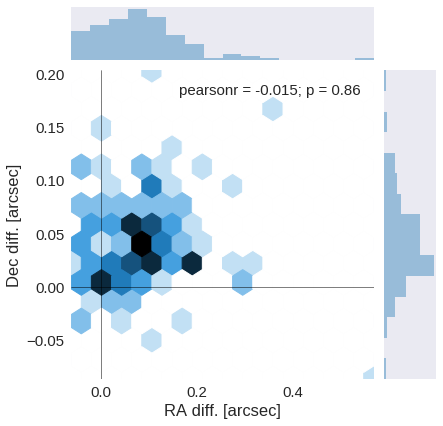

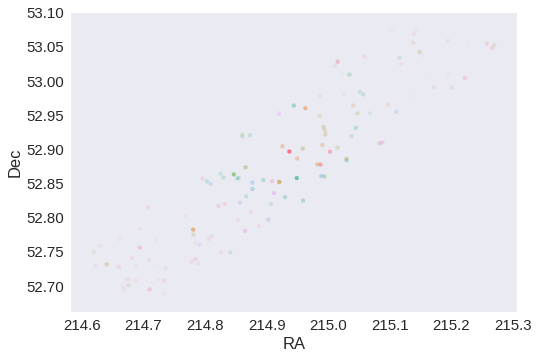

In [9]:
nb_astcor_diag_plot(catalogue[RA_COL], catalogue[DEC_COL], 
                    gaia_coords.ra, gaia_coords.dec)

In [10]:
delta_ra, delta_dec =  astrometric_correction(
    SkyCoord(catalogue[RA_COL], catalogue[DEC_COL]),
    gaia_coords
)

print("RA correction: {}".format(delta_ra))
print("Dec correction: {}".format(delta_dec))

RA correction: -0.07893977393678142 arcsec
Dec correction: -0.034441607530766305 arcsec


In [11]:
catalogue[RA_COL].unit = u.deg
catalogue[DEC_COL].unit = u.deg
catalogue[RA_COL] = catalogue[RA_COL] +  delta_ra.to(u.deg)
catalogue[DEC_COL] = catalogue[DEC_COL] + delta_dec.to(u.deg)

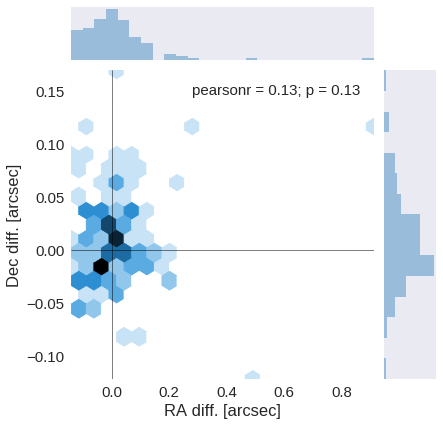

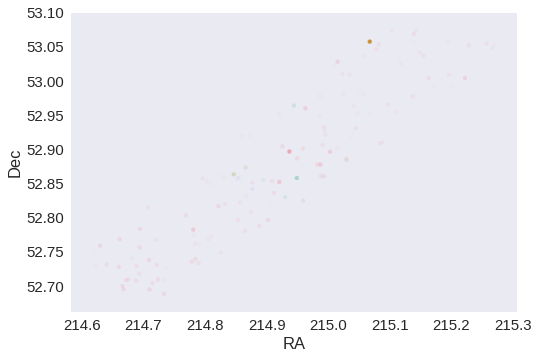

In [12]:
nb_astcor_diag_plot(catalogue[RA_COL], catalogue[DEC_COL], 
                    gaia_coords.ra, gaia_coords.dec)

## IV - Flagging Gaia objects

In [13]:
catalogue.add_column(
    gaia_flag_column(SkyCoord(catalogue[RA_COL], catalogue[DEC_COL]), epoch, gaia)
)

In [14]:
GAIA_FLAG_NAME = "candels-egs_flag_gaia"

catalogue['flag_gaia'].name = GAIA_FLAG_NAME
print("{} sources flagged.".format(np.sum(catalogue[GAIA_FLAG_NAME] > 0)))

160 sources flagged.


# V - Saving to disk

In [15]:
catalogue.write("{}/CANDELS-EGS.fits".format(OUT_DIR), overwrite=True)